Fit Baker et al. data with linear & nonlinear models.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from disp import set_font_size

FPS = 2
DT = 1/FPS
NT = 61
T = DT*np.arange(NT) - 10

IT_STIM = (20, 40)
IDUR_STIM = IT_STIM[1] - IT_STIM[0]
DUR_STIM = DT*IDUR_STIM

T_COLS = [f'IT_{it}' for it in range(NT)]

LOAD_FILE = 'data/simple/pacheco.csv'

In [2]:
# load data
df = pd.read_csv(LOAD_FILE)
df

,EXPT_ID,STIM,FLY,NEUROPIL,NEUROPIL_IDX,RESPONSE_TYPE_LABEL,IT_0,IT_1,IT_2,IT_3,...,IT_51,IT_52,IT_53,IT_54,IT_55,IT_56,IT_57,IT_58,IT_59,IT_60
0,0,S,1,sSADC,0,13,-1.064650,-0.991647,-1.121479,-0.629292,...,0.051085,-0.110480,-0.397804,-0.571073,-0.253161,-0.178974,-0.253286,-0.752629,-0.956365,-0.988533
1,0,P,1,sSADC,0,13,-0.320404,-0.559765,-0.523192,-0.857264,...,-0.691097,-0.449559,-0.457743,-0.512118,-0.287431,-0.309100,-0.569958,-0.905663,-0.689552,-1.064650
2,1,S,1,AMMC,1,13,-0.670883,-0.598723,-0.533291,-0.793913,...,-0.005784,-0.109866,-0.132748,-0.597256,-0.451863,-0.620447,-0.569680,-0.700189,-0.616188,-0.476707
3,1,P,1,AMMC,1,13,-0.744941,-1.096020,-1.057107,-0.811409,...,-0.210221,-0.328872,-0.576546,-0.498928,-0.628736,-0.832286,-0.528669,-0.588112,-0.577622,-0.670883
4,2,S,1,sSADC,0,13,-0.635748,-0.863903,-0.862375,-0.684682,...,-0.608705,-0.415244,-0.465983,-0.616140,-0.812081,-0.932510,-0.772075,-0.831859,-1.007751,-0.918067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38067,19033,P,47,GNG,3,18,-0.773994,-0.749235,-0.769634,-0.770018,...,-0.581494,-0.563422,-0.621782,-0.649898,-0.669798,-0.700001,-0.714815,-0.692207,-0.686311,-0.682736
38068,19034,S,47,sSADC,0,15,-0.419309,-0.535373,-0.702333,-0.963590,...,1.117251,0.243481,0.732199,0.639677,0.828020,0.873257,0.189817,-0.005124,0.224224,0.138849
38069,19034,P,47,sSADC,0,15,-0.052815,-0.259736,-0.696474,-0.727516,...,0.706880,1.258616,0.992831,0.713360,0.680643,0.474997,0.210091,-0.129159,-0.379913,-0.419309
38070,19035,S,47,PLP,7,12,-0.978986,-1.206155,-1.368195,-1.164586,...,-1.015918,-0.829640,-0.580169,-0.611433,-0.154345,0.070995,-0.102384,-0.563238,-0.829081,-1.113682


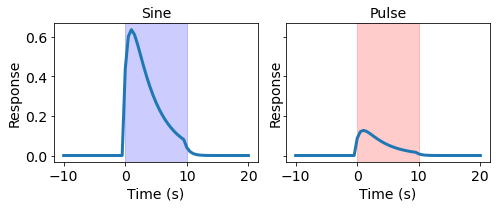

In [3]:
# define smln & obj function
def smlt(tau_r, tau_a, x_s, x_p, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    i_s = np.zeros(NT)
    i_p = np.zeros(NT)
    
    if inp == 's':
        i_s[(t_0 <= T)&(T < t_0+10)] = 1
    elif inp == 'p':
        i_p[(t_0 <= T)&(T < t_0+10)] = 1
 
    r = np.nan*np.zeros(NT)
    
    r[0] = 0
    a_s, a_p = 0, 0
    
    for ct, t_ in enumerate(T[1:], 1):
        a_s += ((DT/tau_a) * (-a_s + x_s*i_s[ct]))
        a_p += ((DT/tau_a) * (-a_p + x_p*i_p[ct]))
        r[ct] = r[ct-1] + (DT/tau_r) * (-r[ct-1] + (x_s - a_s)*i_s[ct] + (x_p - a_p)*i_p[ct])
    
    return r

# test
r_test_s = smlt(tau_r=1, tau_a=4, x_s=1, x_p=.2, t_0=0, inp='s')
r_test_p = smlt(tau_r=1, tau_a=4, x_s=1, x_p=.2, t_0=0, inp='p')

fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True, tight_layout=True)
axs[0].plot(T, r_test_s, lw=3)
axs[0].set_title('Sine')
axs[1].plot(T, r_test_p, lw=3)
axs[1].set_title('Pulse')

for ax, c in zip(axs, ['b', 'r']):
    ax.axvspan(0, 10, color=c, alpha=.2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Response')
    
set_font_size(axs, 14)

In [4]:
# objective function for dynamical system fit
def obj_lin(param, t_0, r_s, r_p):
    # unpack parameters (5 total)
    r_0 = param[0]  # y offset
    tau_r, tau_a, x_s, x_p = param[1:]
    
    pred_s = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
    pred_p = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
    
    # compute error
    sq_err = np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2)
    
    return sq_err

BDS_OBJ = [(None, None), (.001, None), (.001, None), (None, None), (None, None)]

In [5]:
# loop over expt_ids
expt_ids = np.sort(np.unique(df['EXPT_ID']))

cols_pred_dyn = df.columns
data_pred_dyn = []

cols_param_dyn = ['EXPT_ID', 'FLY', 'NEUROPIL', 'NEUROPIL_IDX', 'RESPONSE_TYPE_LABEL', 'FIT_ERR', 'SUCCESS'] + ['T_0', 'R_0', 'TAU_R', 'TAU_A', 'X_S', 'X_P']
data_param_dyn = []

for expt_id in expt_ids:
    sys.stdout.write('.')
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    fly = row_s['FLY']
    neuropil = row_s['NEUROPIL']
    neuropil_idx = row_s['NEUROPIL_IDX']
    response_type_label = row_s['RESPONSE_TYPE_LABEL']
    
    r_s = np.array(row_s[T_COLS])
    r_p = np.array(row_p[T_COLS])
    
    # set initial params 
    p_0 = np.array([0, 2, 5, 1., 1.])  # r_0, tau_r, tau_a, x_s, x_p
    
    # fit model
    obj_best = np.inf
    for t_0 in [-1, -.5, 0, .5]:
        fit_rslt = optimize.minimize(obj_lin, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ)  # try default (BFGS) first
        if not fit_rslt.success:  # try Nelder-Mead
            fit_rsl = optimize.minimize(obj_lin, p_0, args=(t_0, r_s, r_p), bounds=BDS_OBJ, method='Nelder-Mead', options={'maxiter': 1e5})

        if fit_rslt.fun < obj_best:
            fit_rslt_best = copy(fit_rslt)
            t_0_best = t_0
            
            obj_best = fit_rslt.fun
        
    fit_rslt = fit_rslt_best
    t_0 = t_0_best
    p_found = fit_rslt.x
    
    # unpack params
    r_0, tau_r, tau_a, x_s, x_p = p_found
    
    # make predictions
    pred_s = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='s') + r_0
    pred_p = smlt(tau_r, tau_a, x_s, x_p, t_0, inp='p') + r_0
    
    # store predictions
    pred_dict_s = {'EXPT_ID': expt_id, 'STIM': 'S', 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    pred_dict_p = {'EXPT_ID': expt_id, 'STIM': 'P', 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    
    # add time cols
    for it, t_col in enumerate(T_COLS):
        pred_dict_s[t_col] = pred_s[it]
        pred_dict_p[t_col] = pred_p[it]
        
    data_pred_dyn.extend([pred_dict_s, pred_dict_p])
    
    # store params
    param_dict = {'EXPT_ID': expt_id, 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    param_dict['FIT_ERR'] = np.sqrt(np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2))
    param_dict['SUCCESS'] = fit_rslt.success
    param_dict['T_0'] = t_0
    param_dict['R_0'] = r_0
    param_dict['TAU_R'] = tau_r
    param_dict['TAU_A'] = tau_a
    param_dict['X_S'] = x_s
    param_dict['X_P'] = x_p
    
    data_param_dyn.append(param_dict)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [6]:
df_param_dyn = pd.DataFrame(columns=cols_param_dyn, data=data_param_dyn)
df_pred_dyn = pd.DataFrame(columns=cols_pred_dyn, data=data_pred_dyn)

In [7]:
df_param_dyn

,EXPT_ID,FLY,NEUROPIL,NEUROPIL_IDX,RESPONSE_TYPE_LABEL,FIT_ERR,SUCCESS,T_0,R_0,TAU_R,TAU_A,X_S,X_P
0,0,1,sSADC,0,13,0.409826,True,0.5,-0.996550,4.274259,50.112571,3.614242,3.191692
1,1,1,AMMC,1,13,0.372321,True,0.5,-0.970627,4.724727,11.874273,5.349207,4.655381
2,2,1,sSADC,0,13,0.311399,True,0.5,-0.905555,2.864588,67.546912,2.761936,3.052290
3,3,1,sSADC,0,13,0.642185,True,0.5,-0.758159,2.669360,8695.190914,2.196743,2.925729
4,4,1,sSADC,0,16,0.459195,True,0.5,-0.985206,3.970662,4307.738792,2.940083,2.690246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19031,19031,47,PLP,7,15,0.939425,True,0.5,-0.985579,7.937276,2150.794560,3.831645,2.969757
19032,19032,47,sSADC,0,6,0.937118,True,0.5,-0.379068,0.742397,8.162719,3.461983,1.785017
19033,19033,47,GNG,3,18,0.242929,True,0.5,-0.740057,2.295225,86.402222,3.203970,2.570346
19034,19034,47,sSADC,0,15,0.591385,True,0.5,-1.026484,13.239775,9688.701293,6.099361,4.937539


In [8]:
df_pred_dyn

,EXPT_ID,STIM,FLY,NEUROPIL,NEUROPIL_IDX,RESPONSE_TYPE_LABEL,IT_0,IT_1,IT_2,IT_3,...,IT_51,IT_52,IT_53,IT_54,IT_55,IT_56,IT_57,IT_58,IT_59,IT_60
0,0,S,1,sSADC,0,13,-0.996550,-0.996550,-0.996550,-0.996550,...,-0.264614,-0.350235,-0.425840,-0.492602,-0.551553,-0.603609,-0.649575,-0.690164,-0.726004,-0.757653
1,0,P,1,sSADC,0,13,-0.996550,-0.996550,-0.996550,-0.996550,...,-0.350186,-0.425797,-0.492564,-0.551519,-0.603579,-0.649548,-0.690140,-0.725984,-0.757634,-0.785583
2,1,S,1,AMMC,1,13,-0.970627,-0.970627,-0.970627,-0.970627,...,-0.184357,-0.267565,-0.341967,-0.408496,-0.467984,-0.521177,-0.568740,-0.611270,-0.649300,-0.683305
3,1,P,1,AMMC,1,13,-0.970627,-0.970627,-0.970627,-0.970627,...,-0.286341,-0.358756,-0.423508,-0.481408,-0.533180,-0.579473,-0.620868,-0.657881,-0.690978,-0.720572
4,2,S,1,sSADC,0,13,-0.905555,-0.905555,-0.905555,-0.905555,...,-0.613885,-0.664794,-0.706818,-0.741507,-0.770140,-0.793776,-0.813287,-0.829392,-0.842686,-0.853659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38067,19033,P,47,GNG,3,18,-0.740057,-0.740057,-0.740057,-0.740057,...,-0.584679,-0.618527,-0.645002,-0.665709,-0.681905,-0.694573,-0.704481,-0.712231,-0.718293,-0.723034
38068,19034,S,47,sSADC,0,15,-1.026484,-1.026484,-1.026484,-1.026484,...,1.116660,1.035724,0.957845,0.882907,0.810799,0.741414,0.674649,0.610406,0.548589,0.489106
38069,19034,P,47,sSADC,0,15,-1.026484,-1.026484,-1.026484,-1.026484,...,0.708428,0.642909,0.579865,0.519201,0.460828,0.404660,0.350613,0.298607,0.248565,0.200413
38070,19035,S,47,PLP,7,12,-1.141511,-1.141511,-1.141511,-1.141511,...,-0.654724,-0.706983,-0.753631,-0.795272,-0.832443,-0.865623,-0.895241,-0.921679,-0.945279,-0.966345


In [9]:
df_param_dyn.to_csv('data/simple/pacheco_dyn_fit_param.csv', index=False)
df_pred_dyn.to_csv('data/simple/pacheco_dyn_fit_pred.csv', index=False)

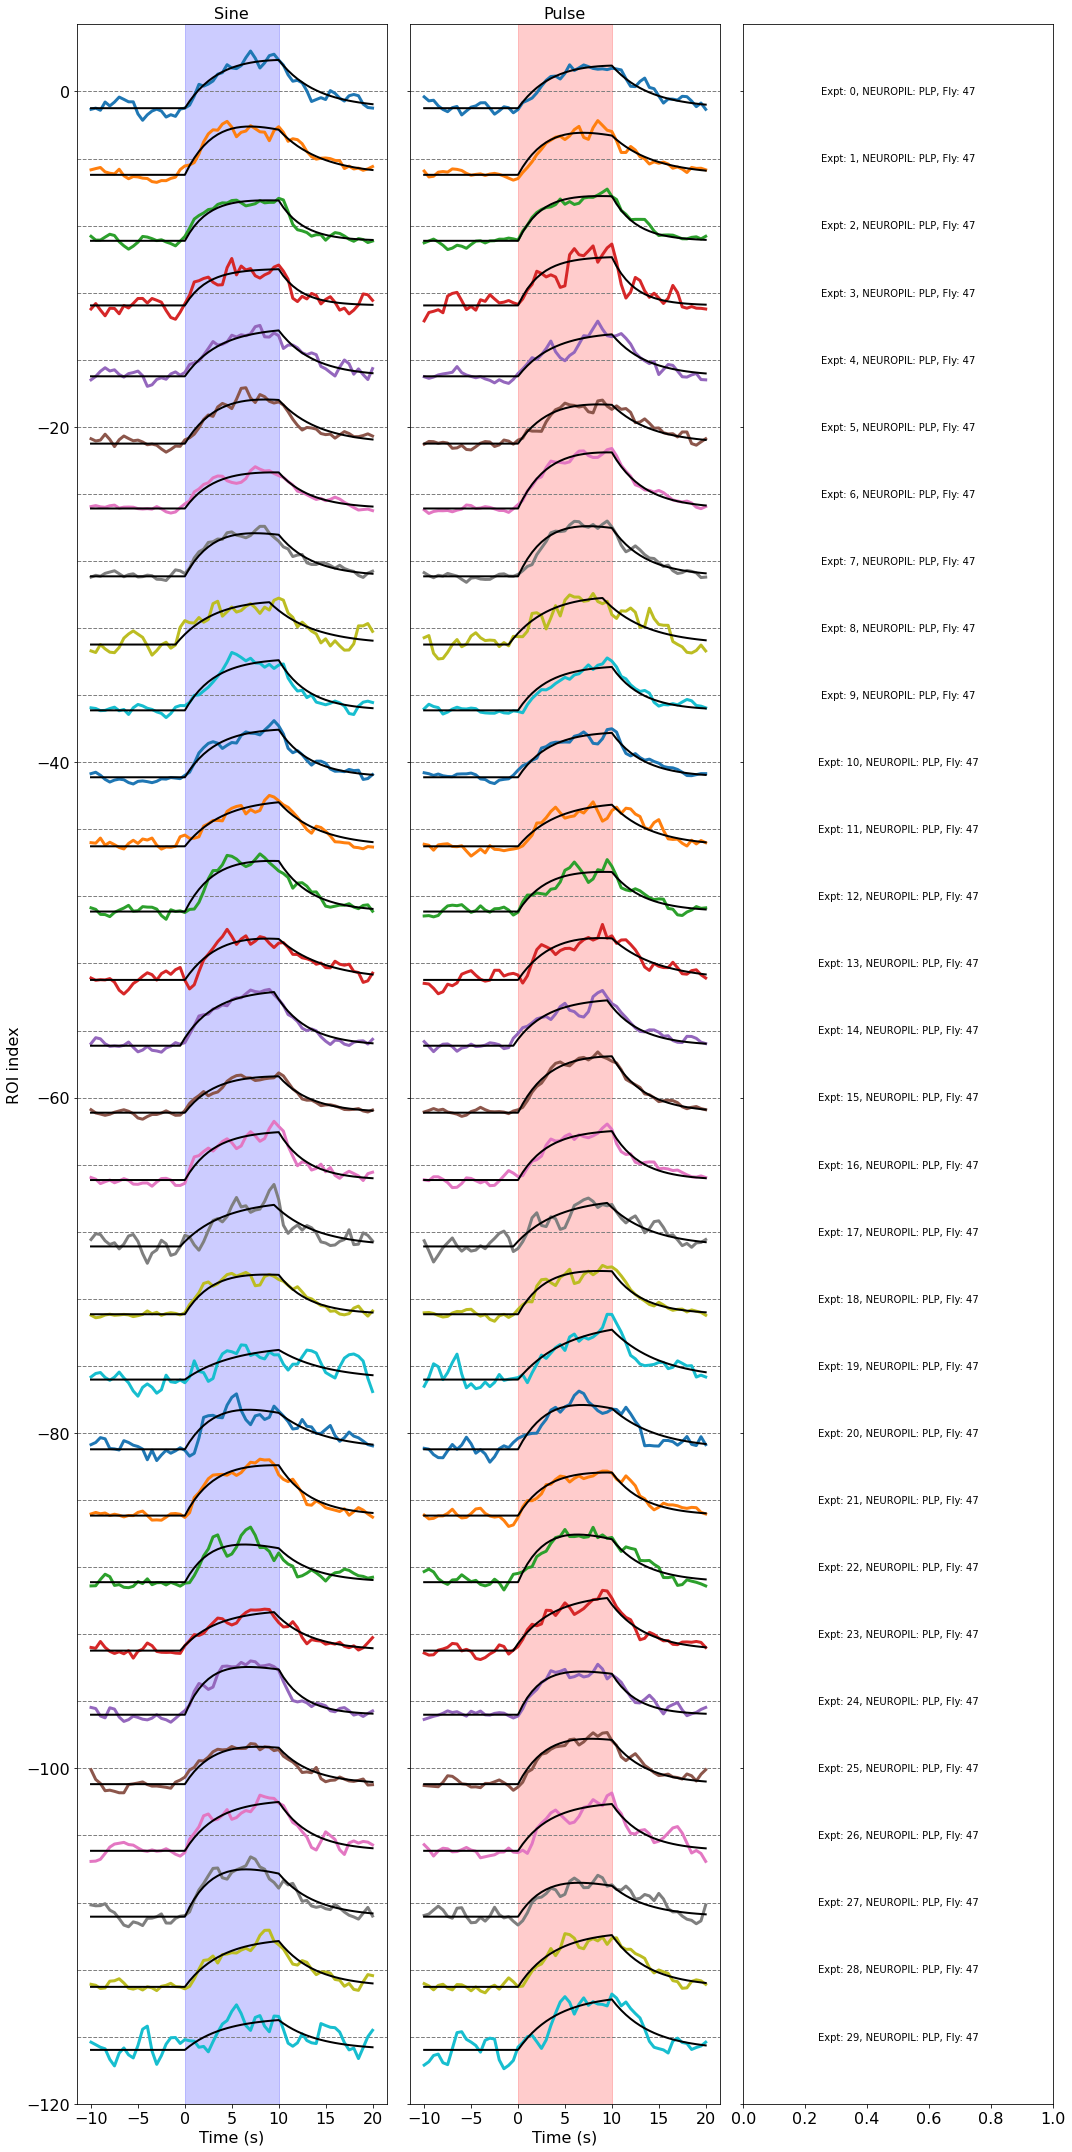

In [10]:
nroi_plot = 30
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids[:nroi_plot]):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, NEUROPIL: {neuropil}, Fly: {fly}', ha='center', va='center')
    
    # prediction
    ## sine response
    row_s = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_dyn[(df_pred_dyn['EXPT_ID'] == expt_id) & (df_pred_dyn['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs[:2], ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)